<a href="https://colab.research.google.com/github/kacper-dobrow/tensorflow-course/blob/main/10_time_series_forecasting_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with tensorflow + Milestone Project 3: BitPredict

Project to predict tomorrow's BTC price based on historical data

## Get data

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-11-14 17:09:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2023-11-14 17:09:09 (5.03 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with Pandas

In [3]:
# Import with pandas
import pandas as pd
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"], # treat the "Date" column as dates
                 index_col=["Date"]) # index by the date column
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
# How many samples
len(df)

2787

2787 samples is not much in case of a deep learning model

In [6]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df.rename(columns={"Closing Price (USD)": "Price"})["Price"]) # Doing it the same way Daniel did produces an error. .rename() method needs to be called on a DataFrame and not Series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


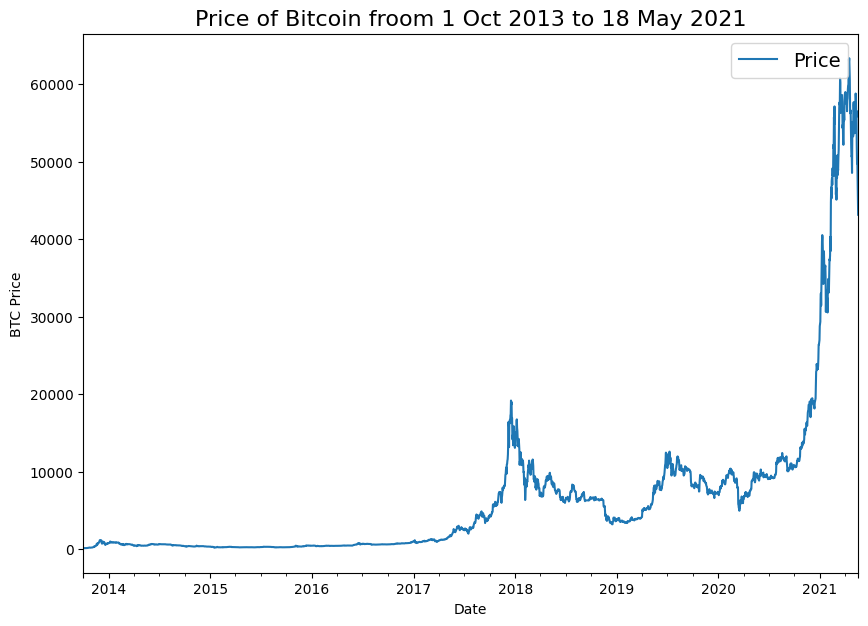

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin froom 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series with CSV module instead of Pandas

When not using Pandas

In [8]:
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip 1st line (gets rid of column names)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1],  "%Y-%m-%d")) # get the date from the line as date not string
    btc_price.append(float(line[2])) # get the price as float

# View 1st 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

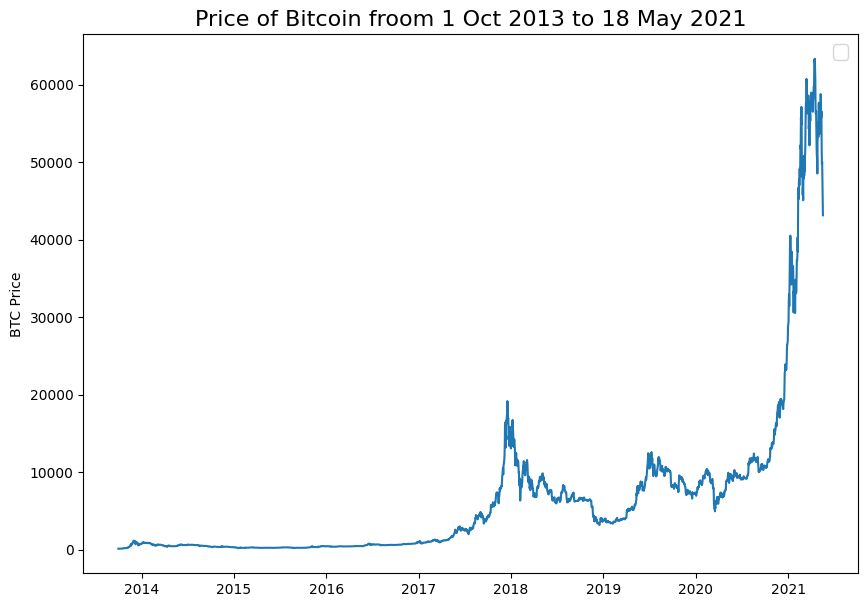

In [9]:
# Plot from CSV
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin froom 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Format data part 1: Create train and test split

### Creating train and test data the wrong way (data leakage)

In [10]:
# Get the date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

In [11]:
# Wrong way to make train/test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=.2, random_state=42)

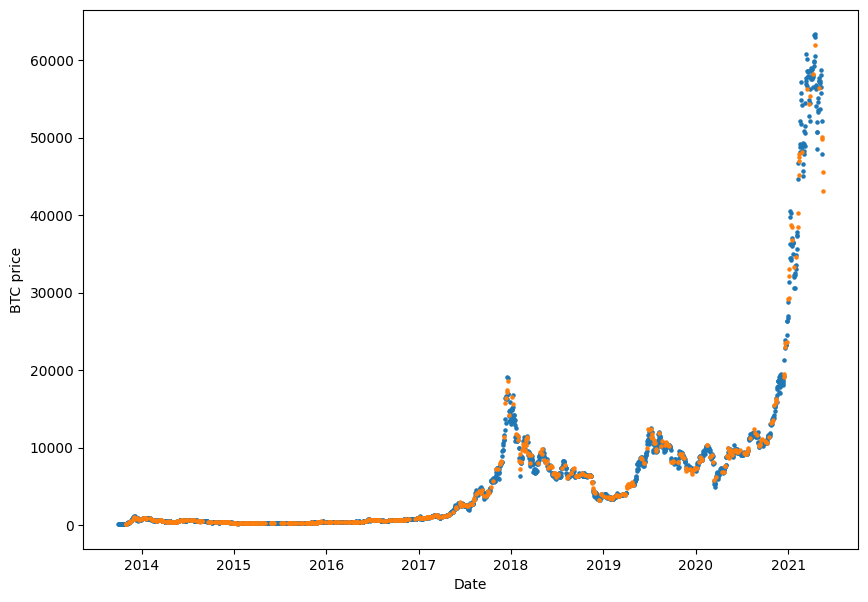

In [12]:
# Plot wrong splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC price")
plt.show();

### Create train and test split the right way

In [13]:
# Create train and test splits
split_size = int(0.8*len(prices)) # 80% train, 20% test

# Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]
# Create test data split
X_test, y_test = timesteps[split_size:], prices[split_size:]

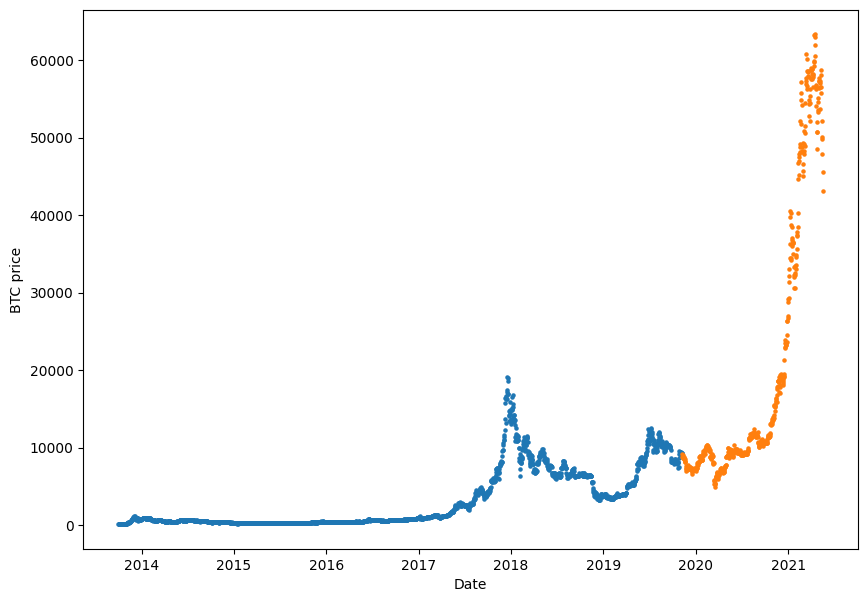

In [14]:
# Plot
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC price")
plt.show();

## Create plotting function

In [15]:
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps against values
  """
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

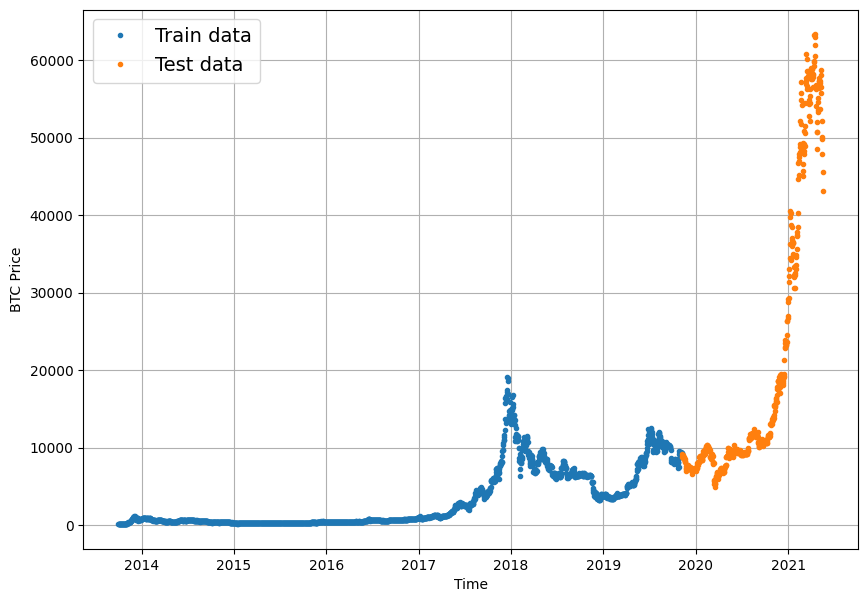

In [16]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, label="Test data")

## Modelling

Terms:
* Horizon - number of timesteps into the future we're going to project
* Window size - number of timesteps to be used when predicting the horizon

Experiments:
0. Naive model (baseline)
1. Dense model, horizon = 1, window = 7
2. Dense model, horizon = 1, window = 30
3. Dense modesl, horizon = 7, window = 30
4. Conv1D
5. LSTM
6. Dense with multivariate data
7. N-BEATs Algorithm
8. Ensemble - multiple models optimized on different loss functions
9. Future prediction model
10. Dense with turkey data

In [17]:
346/426

0.812206572769953

## Model 0: Naive forecast baseline

We just assume the next value is the same as the current one

In [18]:
# Create a naive forecast
naive_forecast = y_test[:-1]

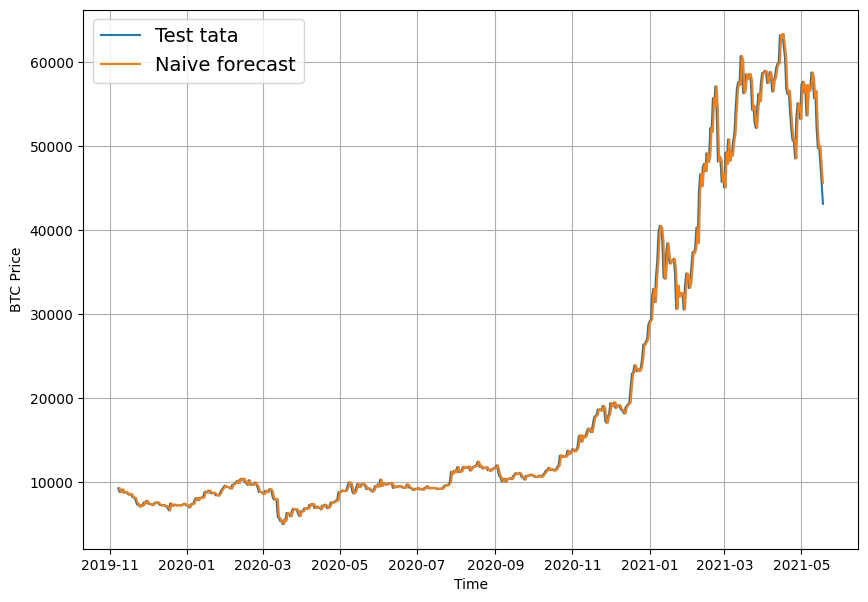

In [19]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(X_train, y_train, label="Train tata")
plot_time_series(X_test, y_test, format="-", label="Test tata")
plot_time_series(X_test[1:], naive_forecast, format="-", label="Naive forecast")

## Evaluating a time series model

Common regression metrics:
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root MSE, easier to interpret than MSE
* (s)MAPE - (symmetric) mean absolute percentage error (not advised)
* MASE - mean absolute scaled error - scaled by error of naive forecast

https://otexts.com/fpp3/accuracy.html

https://github.com/CamDavidsonPilon/Python-Numerics/blob/master/TimeSeries/MASE.py

In [20]:
import tensorflow as tf

In [21]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE, assuming no seasonality/seasonality of 1 day
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season


In [22]:
mean_absolute_scaled_error(y_test[1:], naive_forecast).numpy()

0.9995699939182624

In [23]:
# Multi-metric function for calculating prediction metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype for metric calculations in order for tf not to spew errors
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_true = tf.cast(y_true, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(), # so that it doesn't return tf tensors
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_test[1:], naive_forecast)
naive_results

{'mae': 567.9802183723001,
 'mse': 1147547.0780835983,
 'rmse': 1071.2362382236695,
 'mape': 2.5165248502692306,
 'mase': 0.99957}

## Other models that can be used as baselines and actual forecasts

https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/?ref=mrdbourke.com#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

## Format data part 2: Windowing the the dataset

So that the model predicts on 7 samples

https://www.uber.com/en-PL/blog/forecasting-introduction/

In [25]:
# Set up global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # based on last week

In [26]:
# Create fcn to label windowed data
def get_labelled_window(x, horizon=HORIZON):
  return x[:,:-horizon], x[:, -horizon:]

In [27]:
# Test out the window labelling fcn
test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8), axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[7]], dtype=int32)>)

Instead of using for loops to convert our data into features and labels, we'll use numpy array indexing for speed

https://numpy.org/doc/stable/user/basics.indexing.html

https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [28]:
import numpy as np

#  Function to window the input data
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1 D array into a 2D arrayof sequential labelled windows of window_size with horizon size labels
  """
  # Create a window of specific size
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # Create a 2D array of multiple windows
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  # Use the above to index on the timeseries
  windowed_array = x[window_indexes]
  # Get labelled windows
  windows, labels = get_labelled_window(windowed_array, horizon)

  return windows, labels

# Much much faster than python for loops

In [29]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(2780, 2780)

In [30]:
# View first 3 windows w/ labels
for i in range(3):
  print(f"Window: {full_windows[i]}, label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ], label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ], label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ], label: [125.96116]


In [31]:
# View last 3 windows w/ labels
for i in range(3):
  print(f"Window: {full_windows[i-3]}, label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676], label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472], label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361], label: [43144.47129086]


Actually you can do all that with just the function `tf.keras.preprocessing.timeseries_dataset_from_array` https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

## Turning windows into training and test sets

In [32]:
# Make train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows)*(1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [33]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

## Make a modelling checkpoint callback

To compare each model's best performances


In [34]:
import os

# Create a fcn to implement a checkpoint callback
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model with window = 7 and horizon = 1

* Single dense layer with 128 neurons and ReLU
* Output layer with linear activation
* Adam optimizer and MAE loss fcn
* Batch size of 128
* 100 epochs

https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=pl

In [35]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for reproducibility
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense_7_1")

# Compile
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="mae",
                metrics=["mae","mse"])

# Fit
model_1.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 2s 59ms/step - loss: 2782.0652 - mae: 2782.0652 - mse: 21220040.0000 - val_loss: 5062.7993 - val_mae: 5062.7993 - val_mse: 46524524.0000
Epoch 2/100
18/18 [==============================] - 0s 23ms/step - loss: 398.8729 - mae: 398.8729 - mse: 543333.5625 - val_loss: 954.2167 - val_mae: 954.2167 - val_mse: 2750662.2500
Epoch 3/100
18/18 [==============================] - 0s 25ms/step - loss: 211.1964 - mae: 211.1964 - mse: 201154.0781 - val_loss: 897.4153 - val_mae: 897.4153 - val_mse: 2687863.2500
Epoch 4/100
18/18 [==============================] - 0s 23ms/step - loss: 162.4615 - mae: 162.4615 - mse: 137093.4844 - val_loss: 863.3165 - val_mae: 863.3165 - val_mse: 2476163.5000
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 156.6103 - mae: 156.6103 - mse: 132197.7344 - val_loss: 863.8461 - val_mae: 863.8461 - val_mse: 2395353.7500
Epoch 6/100
18/18 [==============================] - 0s 28ms/step - loss: 153.6

In [36]:
# Evaluate model
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 591.1265 - mae: 591.1265 - mse: 1202852.7500


[591.1265258789062, 591.1265258789062, 1202852.75]

In [37]:
# Load in the saved best performing model
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1_dense_7_1")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 565.3578 - mae: 565.3578 - mse: 1160815.6250


[565.3578491210938, 565.3578491210938, 1160815.625]

In [38]:
naive_results

{'mae': 567.9802183723001,
 'mse': 1147547.0780835983,
 'rmse': 1071.2362382236695,
 'mape': 2.5165248502692306,
 'mase': 0.99957}

## Making forecasts with the model

In [39]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [40]:
# Make predictions and view results
model_1_preds = make_preds(model_1, test_windows)
model_1_results = evaluate_preds(tf.squeeze(test_labels), model_1_preds) # tensors of different shapes
model_1_results

18/18 [==============================] - 0s 1ms/step


{'mae': 565.3578,
 'mse': 1160815.2,
 'rmse': 1077.4114,
 'mape': 2.5342188,
 'mase': 0.99317706}

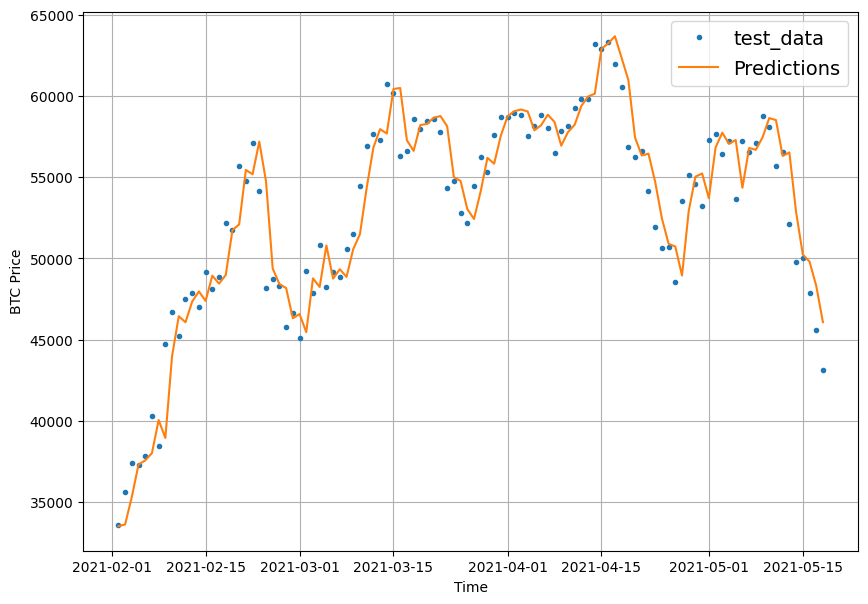

In [41]:
# Plot preds
offset = 450
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="Predictions")

https://otexts.com/fpp2/autocorrelation.html

## Model 2: Dense window = 30, horizon = 1

In [47]:
WINDOW_SIZE = 30

In [49]:
# Make window data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE) # otherwise it takes the WINDOW value specified before fcn definition
len(full_windows), len(full_labels)

(2757, 2757)

In [50]:
# Make train and test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

len(train_windows), len(test_windows)

(2205, 552)

In [51]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense_30_1")

# Compile
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="mae")

# Fit
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [52]:
# Evaluate
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 635.3311


635.3310546875

In [53]:
# Load the best performig one
model_2 = tf.keras.models.load_model("/content/model_experiments/model_2_dense_30_1")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 603.8740


603.8739624023438

In [54]:
# Get forecast predictions
model_2_preds = make_preds(model_2, test_windows)
# Calculate resultd
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

18/18 [==============================] - 0s 2ms/step


{'mae': 603.87396,
 'mse': 1269884.8,
 'rmse': 1126.8916,
 'mape': 2.7564359,
 'mase': 1.0555775}

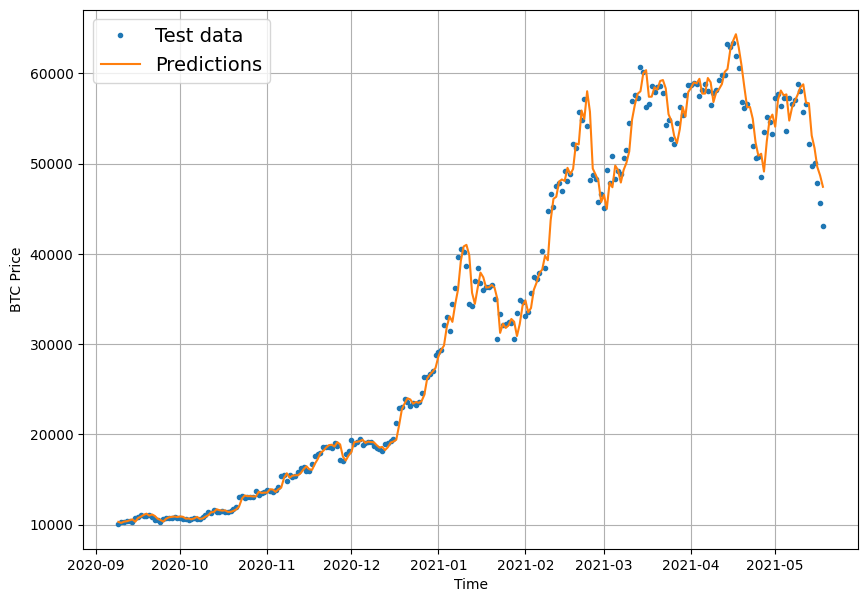

In [58]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(X_test[-len(test_windows):], test_labels[:,0], start=offset, label="Test data")
plot_time_series(X_test[-len(test_windows):], model_2_preds, start=offset, format="-", label="Predictions")

## Model 3: Dense window = 30 horizon = 7

In [59]:
WINDOW_SIZE = 30
HORIZON = 7

# Make window data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
# Make train and test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows)

(2200, 551)

In [60]:
tf.random.set_seed(42)

# Create model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_3_dense_30_7")

# Compile
model_3.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="mae")

# Fit
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [61]:
# Evaluate
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1440.7449


1440.744873046875

In [66]:
# Load the best performig one
model_3 = tf.keras.models.load_model("/content/model_experiments/model_3_dense_30_7")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1235.4626


1235.462646484375

In [67]:
# Get forecast predictions
model_3_preds = make_preds(model_3, test_windows)
# Calculate results
model_3_results = evaluate_preds(tf.squeeze(test_labels), model_3_preds[:,6])
model_3_results

18/18 [==============================] - 0s 1ms/step


{'mae': array([  676.4827  ,   415.75055 ,   314.98004 ,   378.2246  ,
          321.6921  ,   377.2054  ,   492.24457 ,   589.8555  ,
          486.7795  ,   511.14914 ,   731.2834  ,   706.81903 ,
          795.4994  ,   883.1368  ,   653.5037  ,   306.3886  ,
          245.46365 ,   200.2064  ,   195.15381 ,   230.35623 ,
          176.0761  ,   202.87326 ,   388.4029  ,   396.16852 ,
          237.7583  ,   151.75285 ,   119.82701 ,   121.006905,
          162.37402 ,   147.21115 ,   266.8455  ,   366.78256 ,
          327.7073  ,   347.84445 ,   269.79703 ,   276.71713 ,
          281.06683 ,   254.6827  ,   226.0422  ,   242.93652 ,
          470.79904 ,   131.46715 ,    86.862656,    91.11433 ,
           92.576035,   120.405556,    55.799805,    94.66706 ,
          108.86433 ,    92.25495 ,   126.18848 ,    90.08775 ,
          130.8817  ,   204.89153 ,   248.33797 ,   389.49332 ,
          503.81027 ,   563.5487  ,   551.6493  ,   558.4384  ,
          428.64655 ,   202.0551 

## Make the evaluation fcn work for larger horizons

In [68]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype for metric calculations in order for tf not to spew errors
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_true = tf.cast(y_true, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(), # so that it doesn't return tf tensors
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [69]:
model_3_results = evaluate_preds(tf.squeeze(test_labels), model_3_preds)
model_3_results

{'mae': 1235.4626,
 'mse': 5357249.5,
 'rmse': 1416.3392,
 'mape': 5.5189996,
 'mase': 2.1984365}

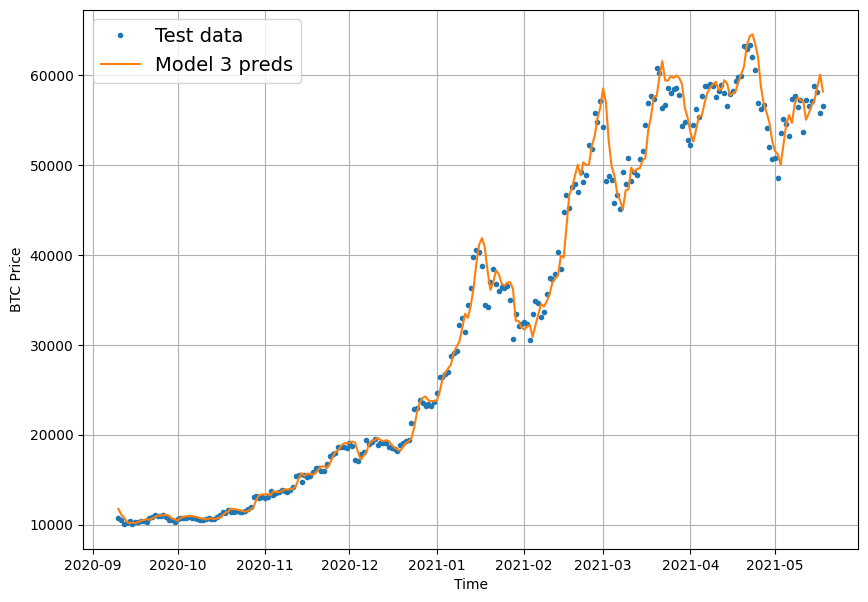

In [74]:
# Plot results
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(X_test[-len(test_windows):], test_labels[:,0], start=offset, label="Test data")
plot_time_series(X_test[-len(test_windows):], tf.reduce_mean(model_3_preds, axis=1), start=offset, label=f"Model 3 preds", format="-")

## Which of the models is performing best so far

https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

<Axes: >

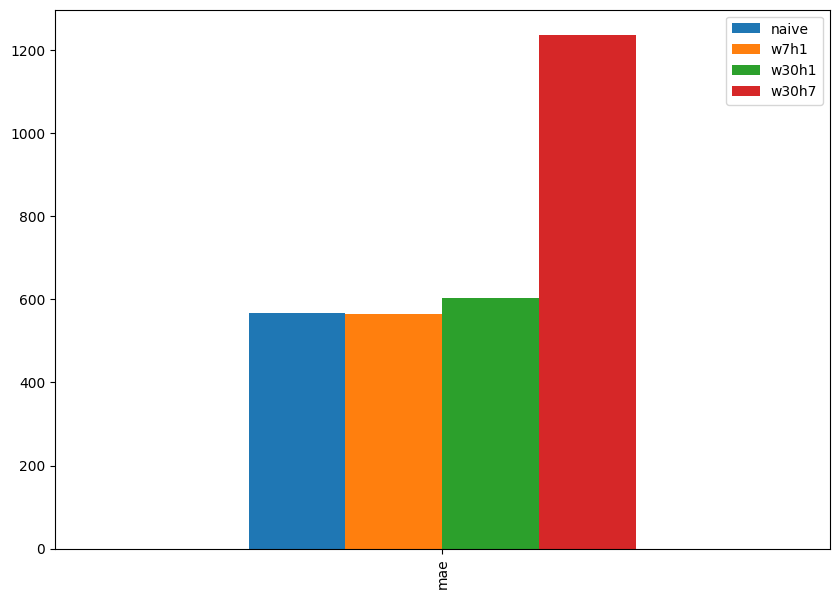

In [75]:
import pandas as pd
pd.DataFrame({"naive": naive_results["mae"],
              "w7h1": model_1_results["mae"],
              "w30h1": model_2_results["mae"],
              "w30h7": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar")

## Model 4: Conv1D

In [76]:
HORIZON = 1
WINDOW_SIZE = 7

In [77]:
# Create a window dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
# Make train and test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

TO use a Conv1D layer we need an input shape of `(batch_size, timesteps, input_dim)`

In [78]:
train_windows[0].shape

(7,)

In [79]:
# Reahape the data
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra layer

In [80]:
# Test the lambda layer
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")

Original shape: (7,)
Expanded shape: (7, 1)


In [82]:
tf.random.set_seed(42)

# Create a model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(128, kernel_size=WINDOW_SIZE, padding="causal", activation="relu"), # Padding specifically for temporal data
    layers.Dense(HORIZON)
], name="model_4_conv1d")

# Compile
model_4.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="mae")

# Fit
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [83]:
model_4.summary()

Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            6400      
                                                                 
 dense_7 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 6529 (25.50 KB)
Trainable params: 6529 (25.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [85]:
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 598.8919


598.8919067382812

In [87]:
model_4 = tf.keras.models.load_model("/content/model_experiments/model_4_conv1d")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 570.9067


570.90673828125

In [89]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds.shape

18/18 [==============================] - 0s 2ms/step


TensorShape([556])

In [90]:
# Evaluate
model_4_results = evaluate_preds(tf.squeeze(test_labels), model_4_preds)
model_4_results

{'mae': 570.90674,
 'mse': 1178646.4,
 'rmse': 1085.6548,
 'mape': 2.55354,
 'mase': 1.002925}

## Model 5: LSTM

In [93]:
tf.random.set_seed(42)

# Create a model the functional way
inputs = layers.Input(shape=WINDOW_SIZE)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # for LSTM layer
# x = layers.LSTM(128, return_sequences=True)(x) # return_sequences=True needed if the LSTMs are stacked
x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5_LSTM")

# Compile
model_5.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="mae")

# Fit
model_5.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 [==============================] - 3s 86ms/step - loss: 2616.7100 - val_loss: 12089.5381
Epoch 2/100
18/18 [==============================] - 1s 70ms/step - loss: 1122.5334 - val_loss: 1728.3298
Epoch 3/100
18/18 [==============================] - 1s 70ms/step - loss: 283.4679 - val_loss: 1118.8572
Epoch 4/100
18/18 [==============================] - 1s 67ms/step - loss: 219.4935 - val_loss: 1112.5746
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 204.3181 - val_loss: 1170.8685
Epoch 6/100
18/18 [==============================] - 59s 3s/step - loss: 198.4174 - val_loss: 1099.3329
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 196.1600 - val_loss: 1107.4928
Epoch 8/100
18/18 [==============================] - 0s 5ms/step - loss: 193.5637 - val_loss: 1111.5531
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 191.8961 - val_loss: 1103.7770
Epoch 10/100
18/18 [==============================] - 1s 

In [94]:
# Load in the best version of model 5 and evaluate
model_5 = tf.keras.models.load_model("/content/model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 1s 4ms/step - loss: 607.8505


607.8505249023438

In [95]:
# make preds
model_5_preds = make_preds(model_5, test_windows)
model_5_preds.shape

18/18 [==============================] - 0s 1ms/step


TensorShape([556])

In [97]:
# Evaluate
model_5_results = evaluate_preds(tf.squeeze(test_labels), model_5_preds)
model_5_results

{'mae': 607.85046,
 'mse': 1306120.5,
 'rmse': 1142.8563,
 'mape': 2.7487872,
 'mase': 1.067825}

## Make a multivariate time series

Add BTC halving events

https://www.cmcmarkets.com/en-nz/learn-cryptocurrencies/bitcoin-halving

In [98]:
# Let's add these to the dataset
block_reward_1 = 50 # 3 January 2009 - out of our dtaset
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25# 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [ ]:
# Create date ranges of cpecific block_reward values